In [ ]:
!pip install pymc

     |████████████████████████████████| 385 kB 5.3 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1353164 sha256=f9ba1c26d1844816e193d46a9033d92b1e8bdda3e74aacd7be23ffbc8f0334f8
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pymc as pm

import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



## Monty Hall

Suppose you're on a game show, and you're given the choice of three doors: Behind one door is a car, and behind the others, goats. You pick a door, say *No.1*, and the host, who knows what's behind the doors, opens another door, say *No.3*, which has a goat. He then asks you *"Do you want to pick door No.2?"*. Is it to your advantage to switch to your choice?

In [ ]:
car_door = pm.DiscreteUniform("car_door", lower=1, upper=3)
picked_door = pm.DiscreteUniform("picked_door", lower=1, upper=3)
host_preference = pm.DiscreteUniform("preference", lower=0, upper=1)

In [ ]:
@pm.deterministic
def host_choice(car_door=car_door, picked_door=picked_door, host_preference=host_preference):
  if car_door != picked_door:
    return 6 - car_door - picked_door
  
  if car_door == 1:
    goat_door1, goat_door2 = 2, 3
  else:
    goat_door1 = 2
    if car_door == 2:
      goat_door2 = 3
    else:
      goat_door2 = 2
  
  out = goat_door1 if not host_preference else goat_door2
  return out

In [ ]:
@pm.deterministic
def switch_door(picked_door=picked_door, host_choice=host_choice):
  return 6 - picked_door - host_choice

In [ ]:
model = pm.Model([car_door, picked_door, host_preference, host_choice, switch_door])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

car_door_samples = mcmc.trace('car_door')[:]
picked_door_samples = mcmc.trace('picked_door')[:]
changed_door_samples = mcmc.trace('switch_door')[:]

print('The probability to win the game if the player stays with the initial choice: ',
      (picked_door_samples == car_door_samples).mean())
print('The probability to win the game if the player switch the doors: ',
      (changed_door_samples == car_door_samples).mean())

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 5.8 secThe probability to win the game if the player stays with the initial choice:  0.332
The probability to win the game if the player switch the doors:  0.7229666666666666


## Laboratory I

https://docs.google.com/document/d/13JRmdvOuGqxEXgT71eoibc1EGWrftpul/edit#

2) a) Write the PyMC code that computes the value of L* (given the above formula) when X = c with probability one and when X is a random variable uniform on [0, 4c]. How the results compare with the theoretical ones presented above?

In [ ]:
c = 4
X = pm.Uniform("X", lower = 0, upper = 4 * c)

@pm.deterministic
def loss_a(X = X, c = c):
  return min(X, c) / (c + X)

mcmc = pm.MCMC([X, loss_a])
mcmc.sample(40000,10000,1)

loss_star_a = mcmc.trace('loss_a')[:]
print('\n', loss_star_a.mean())


 [-----------------100%-----------------] 40000 of 40000 complete in 2.4 sec
 0.30524262114566547


In [ ]:
def nyu(X, c):
  return X / (X + c)

def g_star(X, c):
  if nyu(X, c) > 0.5:
    return 1
  return 0

@pm.deterministic
def loss_b(X = X, c = c):
  return g_star(X, c)

Y = pm.Bernoulli('Y', X / (c + X))

mcmc = pm.MCMC([X, Y, loss_b])
mcmc.sample(40000, 10000, 1)

loss_star_b = mcmc.trace('loss_b')[:]
Y_trace = mcmc.trace('Y')[:]
Y_trace = list(map(int, Y_trace))

distinct_counter = 0
for real, expected in zip(Y_trace, loss_star_b):
  if expected != real:
    distinct_counter += 1

print()
print(distinct_counter / len(Y_trace))

 [-----------------100%-----------------] 40000 of 40000 complete in 4.3 sec
0.30893333333333334


## Inferring behaviour from text-messages data

In [ ]:
figsize(12, 4)
count_data = np.loadtxt('/content/gdrive/MyDrive/data/txtdata (1).csv') # observed data
n_count_data = len(count_data)
print(n_count_data) # number of days observed

74


(0.0, 74.0)

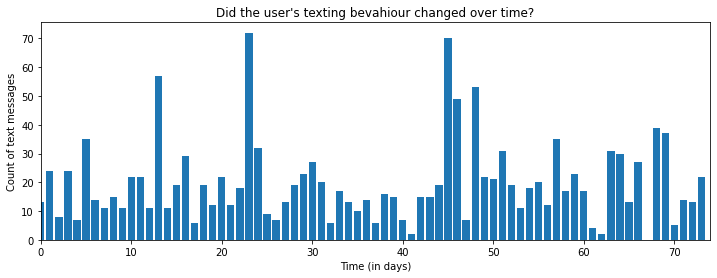

In [ ]:
plt.bar(np.arange(n_count_data), count_data)
plt.xlabel('Time (in days)')
plt.ylabel('Count of text messages')
plt.title('Did the user\'s texting bevahiour changed over time?')
plt.xlim(0, n_count_data)

In [ ]:
alpha = 1.0 / count_data.mean()
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
tau = pm.DiscreteUniform("tau", lower = 0, upper = n_count_data) 

In [ ]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
  out = np.zeros(n_count_data)
  out[:tau] = lambda_1
  out[tau:] = lambda_2
  return out

In [ ]:
observations = pm.Poisson("obs", lambda_, size=n_count_data, value=count_data, observed=True)

model = pm.Model([observations, tau, lambda_1, lambda_2])
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)


/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 6.9 sec

In [ ]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

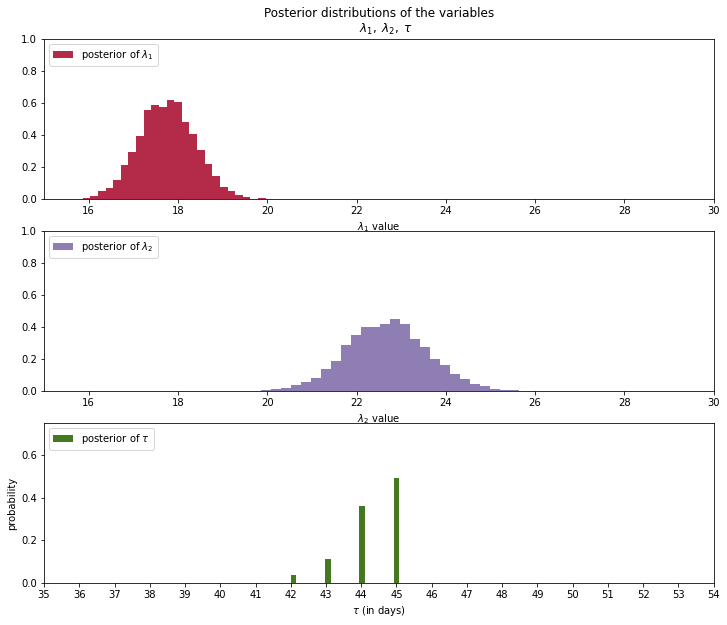

In [ ]:
figsize(12, 10)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");


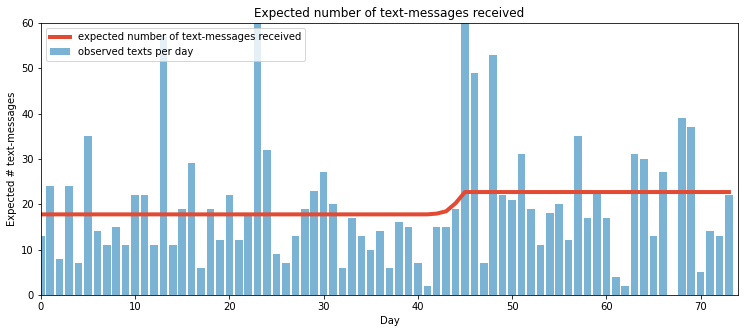

In [ ]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

## Laboratory II

**1.** What is the mean of $\lambda_1$ given that we know tau is less than 45. That is, suppose we have been given new information that the change in behaviour occurred prior to day 45. What is the expected value of $\lambda_1$ now? (You do not need to redo the PyMC part. Just consider all instances where tau_samples < 45.)

In [ ]:
new_lambda_1 = lambda_1_samples[tau_samples[tau_samples < 45.]]
print(new_lambda_1.mean())

18.231877082576528


**2.** Extend the previous model to consider two switchpoints.

In [ ]:
print("Number of days: ", n_count_data)
print("The mean of the text messages: ", count_data.mean())

alpha = 1.0 / count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)

tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data)
tau_2 = pm.DiscreteUniform("tau_2", lower=0, upper=n_count_data)

@pm.deterministic
def lambda_(tau_1=tau_1, tau_2=tau_2, lambda_1=lambda_1, lambda_2=lambda_2, lambda_3=lambda_3):
  out = np.zeros(n_count_data)
  out[:tau_1] = lambda_1
  out[tau_1:tau_2] = lambda_2
  out[tau_2:] = lambda_3
  return out


observations = pm.Poisson("obs", lambda_, value=count_data, size=n_count_data, observed=True)

model = pm.Model([observations, tau_1, tau_2, lambda_1, lambda_2, lambda_3])
mcmc = pm.MCMC(model)
mcmc.sample(40000,10000,1)

Number of days:  74
The mean of the text messages:  19.743243243243242


/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 11.7 sec

# Laboratory III

P1. The absolute difference between two independent standard uniform variables - uniform on (0,1) - has a particular triangular distribution (see https://en.wikipedia.org/wiki/Triangular_distribution).

  a) Use this particular triangular distribution PDF to generate a sample for the absolute difference between two independent standard uniform variables

  b) Can you generate a sample for the absolute difference between two independent standard uniform variables directly (without using the triangular distribution)?


/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)
/usr/local/lib/python3.7/dist-packages/pymc/StepMethods.py:773: UserWarning: DrawFromPrior jumped to forbidden value
  warnings.warn('DrawFromPrior jumped to forbidden value')


 [-----------------100%-----------------] 40000 of 40000 complete in 1.5 sec

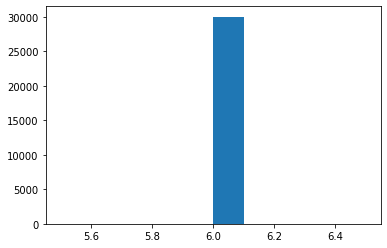

In [ ]:
################################################################################
#   The triangular distribution is a continuous probability with lower limit a, 
# upper limit b and mode c, wehere a < b and a <= c <= b.
################################################################################
a = 2 # lower limit
b = 7 # upper limit
c = 6 # mode

@pm.stochastic
def Z(value = c, a = a, b = b, c = c):
  def logp(value, a, b, c):
    if value < 0:
      return -np.inf

    if a <= value < c:
      return np.log(2. * (value - a) / ((b - a) * (b - c)))

    if value == c:
      return np.log(2. / (b - a))

    if c < value <= b:
      return np.log(2. * (b - value) / ((b - a) * (b - c)))

    return -np.inf

  def random(a, c, b):
    np.random.triangular(a, c, b)

model = pm.Model([Z])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

Z_samples = mcmc.trace('Z')[:]

plt.hist(Z_samples, bins = 10)
plt.show()

The triangular distribution is often used in ill-defined problems where the underlying distribution is not known, but some knowledge of the limits and mode exists.

In [ ]:
# example of directly initialize a pymc.Stochastic

def triangular_logp(value, a, b, c):
  if a <= value < c:
    return np.log(2. * (value - a) / ((b - a) * (b - c)))

  if value == c:
    return np.log(2. * (b - a))

  if c < value <= b:
    return np.log(2 * (b - a) / ((b - a) * (b - c)))

  return -np.inf

def triangular_random(a, b, c):
  return np.ramdom.triangular(a, c, b)

Z = pm.Stochastic(logp=triangular_logp,
                  doc="Triangular Distribution",
                  name="Z",
                  parents={'a':-3, 'b':8, 'c':0},
                  random=triangular_random,
                  trace=True,
                  value=0,
                  dtype=float,
                  rseed=1,
                  observed=False,
                  verbose=0)

## Privacy Algorithm

In the interview process for each student, the student flips a coin hidden from the interviewer. The student agrees to answer honestly if the coin comes up heads. Otherwise, if the coin comes up tails, the student (secretly) flips the coin again and answers "Yes, I did cheat" if the coin flip lands heads, and "No, I did not cheat" if the coin flip lands tail. This way, the interviewer does not know if a "Yes" was the result of a guilty plea or a Heads on a second coin toss. Thus privacy is preserved and the researchers receive honest answers.

Suppose 100 students are being surveyed for cheating, and we wish to find **p**, the proportion of cheaters. Since we are quite ignorant about **p**, we will asign it a **Uniform** (0,1) prior. 

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 12.8 sec

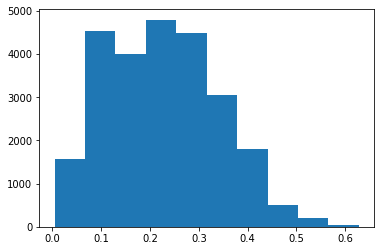

In [ ]:
num_students = 100

p = pm.Uniform("frequency_cheating", 0, 1)

# We assign Bernoulli random variables to the 100 students: 1 implies they cheated and 0 implies they did not.
honestly_answers = pm.Bernoulli("truths", p, size=num_students)

# The first coin flip can be modeled by sampling 100 Bernoulli random variables with p = 1/2 (supposing the coin is fair)
first_coin_flip = pm.Bernoulli("first_flip", 0.5, size=num_students)
# Although not every student flips the second time:
max_num_snd_coin_flip = num_students
second_coin_flip = pm.Bernoulli("second_flip", 0.5, size=max_num_snd_coin_flip)

# Using the previous variables, we can return a posible realization of the observed proportion of "Yes" responses

@pm.deterministic
def observed_proportion(true_answers=honestly_answers, fc=first_coin_flip, sc=second_coin_flip):
  observed = fc * true_answers + (1 - fc) * sc
  return observed.sum() / (1. * num_students)

# Supposr that after performing our own coin-flip interview, the researcher received 35 "Yes" responses.
# The researcher observed a Binomial random variable, with N=100 and p=observed_proportion with value=35
X = 35
yes_answers = pm.Binomial("obs", num_students, observed_proportion, observed=True, value=X)

model = pm.Model([p, honestly_answers, first_coin_flip, second_coin_flip, observed_proportion, yes_answers])

mcmc = pm.MCMC(model)
mcmc.sample(40000,15000)
p_trace = mcmc.trace("frequency_cheating")[:]

plt.hist(p_trace)
plt.show()

# Burglar System (example of a Bayesian Network)

You have a new burglar alarm installed at home. It is fairly reliable at detecting a burglary but also responds on occasion to a minor earthquake. You also have two neighbors, John and Mary, who have promised to call you at work when they hear the alarm. John nearly always calls when he hears the alarm, but sometimes confuses the telephone ringing with the alarm and call then, too. Mary, on the other hand, likes rather loud music and often misses the alarm altogether. Given the evidence of who has or has not called, we would like to estimate the probability of a Burglary.

In the Burglary network, we might observe the event in which *JohnCalls = True* and *MaryCalls = True*. We  could then ask for, say, the probability that a burglary has occured. This mean the posterior distribution of **P(B|J=t, M=t)**. 

In [ ]:
B = pm.Bernoulli("B", 0.001)
E = pm.Bernoulli("E", 0.002)

p_A = pm.Lambda("p_A", lambda B=B, E=E:
                np.where(B, np.where(E, .950, .940), np.where(E, .290, .001)))
A = pm.Bernoulli("A", p_A)

p_J = pm.Lambda("p_J", lambda A=A: np.where(A, .90, .05))
p_M = pm.Lambda("p_M", lambda A=A: np.where(A, .70, .01))

J = pm.Bernoulli("J", p_J, value=[1], observed=True)
M = pm.Bernoulli("M", p_M, value=[1], observed=True)

model = pm.Model([B, E, A, J, M])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

B_samples = mcmc.trace("B")[:]
print()
print("Burglary probability: ", B_samples.mean())

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 10.2 sec
Burglary probability:  0.27836666666666665


# German Tank Problem

- Estimating the total number of tanks from a small sample

Suppose 4 tanks are captured with the serial numbers 10, 256, 202, and 97. Assuming that each tank is numbered in sequence as they are built, how many tanks are there in total?

The problem consists in estimating the maximum of a discrete uniform distribution from sampling without replacement. In simple terms, suppoose we have an unknown number of items which are sequentially numbered from 1 to N. We take a random sample of these items and observe their sequence numbers; the problem is to estimate N from these observed numbers.

The problem can be approached using either frequentist inference or Bayesian inference.

In [ ]:
from IPython.display import display, Math

**The Model**

---

Since we do not want a singular estimate, we want a probability distribution for the total number of tanks. Therefore, we need to calculate the distribution of total tanks N, given the serial numbers D:

In [ ]:
latex= r'$P(N|D) \propto P(D|N)P(N)'
Math(latex)

<IPython.core.display.Math object>

To decide how to model the likelihood, we can think about how we would create our data. Simply, we just have some numbers of tanks, with serial numbers 1, 2, ..., N, and we uniformly draw four tanks from the group. Therefore, we should use a discrete uniform distribution:

In [ ]:
latex=r'$P(D_i|N) \sim DiscreteUniform(0,N)'
Math(latex)

<IPython.core.display.Math object>

Consider the prior information N, P(N). We know that it has to be at least equal to the largest serial  number, m. As for an upper bound, we can guess that it isn't into the millions, since every serial number we saw is less than 300.

In [ ]:
latex=r'$P(N) \sim DiscreteUniform(m,10000)'
Math(latex)

<IPython.core.display.Math object>

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 2.8 sec

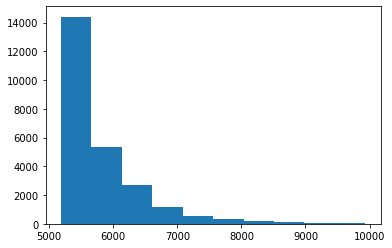

In [ ]:
true_N = 5345

D = pm.rdiscrete_uniform(1, true_N, size=10)
N = pm.DiscreteUniform("N", lower=D.max(), upper=10000)

observations = pm.DiscreteUniform("obs", lower=0, upper=N, value=D, observed=True)

model = pm.Model([D, N, observations])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)
N_samples = mcmc.trace("N")[:]

plt.hist(N_samples)
plt.show()

# The Lighthouse Problem

There exists a lighthouse α miles along a straight coastline (relative to some position x = 0 and β miles offshore. As it rotates, it briefly flashes highly collimated beans of light at random intervals, each time the lighthouse flashes the angle of the bean is sampled uniformly between \[-π\/2, π/2]. We have light detectors along the coastline, and so far the *kth* time the light flashes (not counting the times the light is facing away from the coast) we record a position
xk. Given a sequence of observations, infer the position coordinates α and β. 

In [ ]:
# The parameters to be inferred. We only know them here because we are synthesising the data.
true_alpha = 10
true_beta = 50

num_flashes = 5000

# Generate the angles
true_thetas = np.random.uniform(low=-0.5*np.pi, high=0.5*np.pi, size=num_flashes)

# Generate the x coordinates of the flashes along the coastline
data = true_alpha + true_beta * np.tan(true_thetas)

In [ ]:
# Our prior distribution on alpha and beta
# Alpha is normally distributed with a standard deviation of 50 miles
# Beta is exponentially distributed with a mean of 100 miles
alpha = pm.Normal('alpha', 0, 1.0 / 50 ** 2)
beta = pm.Exponential('beta', 1.0 / 100)
# We have a prior distributuion for the angle of the lighthouse for every time we observed a flask
thetas = pm.Uniform('thetas', lower=-0.5 * np.pi, upper = 0.5 * np.pi)

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 59.0 sec

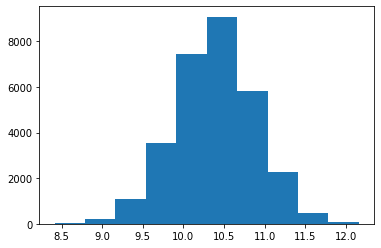

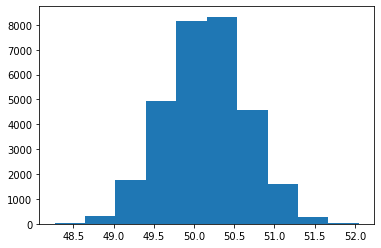

In [ ]:
@pm.observed(name="obs", dtype=np.float64)
def obs(value=data, alpha=alpha, beta=beta):
  return np.sum(np.log(beta) - np.log(np.pi) - np.log(beta**2 + (alpha-value)**2))

model = pm.Model([alpha, beta, obs])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)


alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]

# histogram of the samples:

plt.hist(alpha_samples)
plt.show()

plt.hist(beta_samples)
plt.show()

# Laboratory IV

In [ ]:
B = pm.Bernoulli("B", 0.0010)
E = pm.Bernoulli("E", 0.0020)
F = pm.Bernoulli("F", 0.0015)

p_A = pm.Lambda("p_A", lambda B=B, E=E, F=F:
                np.where(B, 
                         np.where(E, np.where(F, .955, .950), np.where(F, .93, .94)), 
                         np.where(E, np.where(F, .295, .290), 
                                  np.where(F, .001, .0005))))
A = pm.Bernoulli("A", p_A)

p_J = pm.Lambda("p_J", lambda A=A: np.where(A, .90, .05))
p_M = pm.Lambda("p_M", lambda A=A: np.where(A, .70, .01))

J = pm.Bernoulli("J", p_J, value=[1], observed=True)
M = pm.Bernoulli("M", p_M, value=[1], observed=True)

model = pm.Model([B, E, A, J, M])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

B_samples = mcmc.trace("B")[:]
print()
print("Burglary probability: ", B_samples.mean())

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 40000 of 40000 complete in 10.6 sec
Burglary probability:  0.32743333333333335


# Laboratory V

2. 

 [-----------------100%-----------------] 100000 of 100000 complete in 52.4 sec

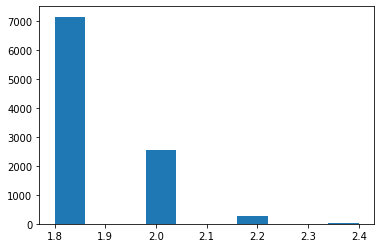

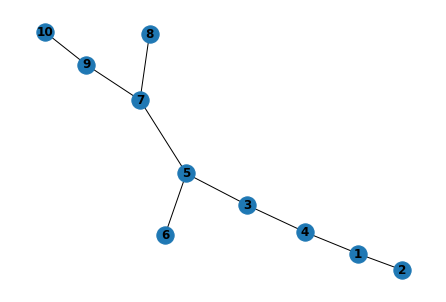

 [-----------------100%-----------------] 100 of 100 complete in 0.1 sec

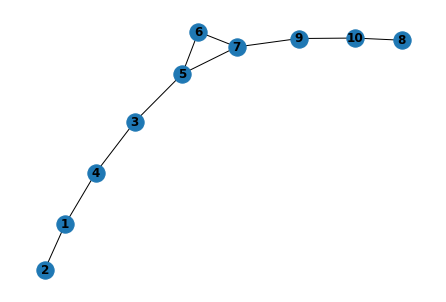

 [-----------------100%-----------------] 100 of 100 complete in 0.1 sec

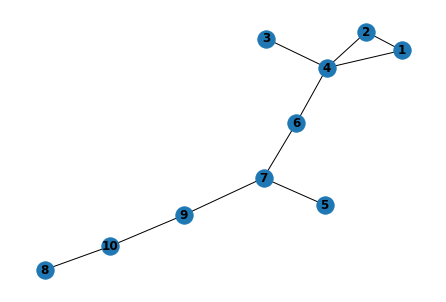

In [ ]:
import numpy as np
import pymc as pm
import networkx as nx
from matplotlib import pyplot as plt

alpha = 0.5
beta = 0.1
L= 9.0

G0 = nx.Graph()

for i in range(1, 10):
    for j in range(i + 1, 11):
        G0.add_edge(i, j)

# G0.add_path(range(1, 11))

# G0.add_path(range(1, 11))
# G0.remove_edge(2, 3)
# G0.remove_edge(3, 4)
# G0.add_edge(2, 4)
# G0.add_edge(3, 7)
# G0.add_edge(8, 10)

# nx.draw(G0, with_labels=True, font_weight='bold')
# plt.show()


@pm.stochastic(dtype=nx.Graph)
def cwg(value = G0, alpha = alpha, beta = beta, L = L):
    tmp = 0
    for i in range(1, len(value)):
        for j in range(i + 1, len(value)+1):
            if value.has_edge(i, j):
                tmp += np.log(alpha) - ((j - i) / (beta * L))
            else:
                tmp += np.log(1 - alpha * np.exp((i - j) / (beta * L)))
    return tmp


class CWGMetropolis(pm.Metropolis):
    """ A PyMC Step Method that walks on connected Waxman Graphs by
        choosing two distinct nodes at random and considering the 
        possible link between them. If the link is already in the
        graph, it consider it for deletion, and if the link is not in
        the graph, it consider it for inclusion, keeping it with the
        appropriate Metropolis probability (no Hastings factor necessary,
        because the chain is reversible, right?)

    """
    def __init__(self, stochastic):
        # Initialize superclass
        pm.Metropolis.__init__(self, stochastic, scale=1., verbose=0, tally=False)

    def propose(self):
        """ Add an edge or remove an edge"""
        G = self.stochastic.value

        G.u_new = np.random.choice(G.nodes()); G.v_new = np.random.choice(G.nodes())
        while G.u_new == G.v_new:
            G.v_new = np.random.choice(G.nodes())

        if G.has_edge(G.u_new, G.v_new):
            G.remove_edge(G.u_new, G.v_new)
            if not nx.is_connected(G):
                G.add_edge(G.u_new, G.v_new)
        else:
            G.add_edge(G.u_new, G.v_new)
        self.stochastic.value = G

    def reject(self):
        """ Restore the graph"""
        G = self.stochastic.value
        if G.has_edge(G.u_new, G.v_new):
            G.remove_edge(G.u_new, G.v_new)
        else:
            G.add_edge(G.u_new, G.v_new)
        self.rejected += 1
        self.stochastic.value = G

@pm.deterministic
def average_degree(G = cwg):
   return np.sum([t[1] for t in list(G.degree())]) / len(G)
    # return np.sum(list(G.degree().values())) / len(G)

mcmc = pm.MCMC([cwg, average_degree])
mcmc.use_step_method(CWGMetropolis, cwg)
mcmc.sample(100000)

avgd_samples = mcmc.trace("average_degree")[:]

plt.hist(avgd_samples[90000:])
plt.show()

nx.draw(cwg.value, with_labels=True, font_weight='bold')
plt.show()

mcmc.sample(100)

nx.draw(cwg.value, with_labels=True, font_weight='bold')
plt.show()

mcmc.sample(100)

nx.draw(cwg.value, with_labels=True, font_weight='bold')
plt.show()

# Laboratory VI

Multi-armed bandit

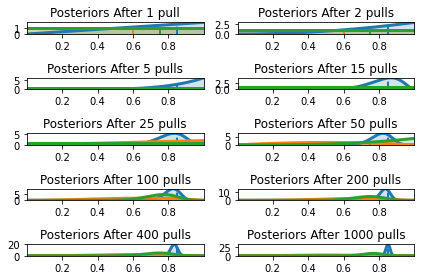

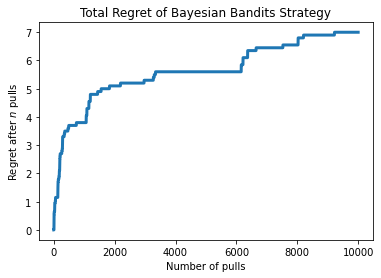

In [ ]:
import numpy as np
import scipy.stats as stats
from pymc import rbeta
from matplotlib import pyplot as plt

class Bandits(object):

    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """

    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def pull(self, i):
        # i is which arm to pull
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)

class BayesianStrategy(object):

    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """

    def __init__(self, bandits):

        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    def sample_bandits(self, n=1):

        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # sample from the bandits's priors, and select the largest sample
            choice = np.argmax(rbeta(1 + self.wins, 1 + self.trials - self.wins))

            # sample the chosen bandit
            result = self.bandits.pull(choice)

            # update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

beta = stats.beta
x = np.linspace(0.001, .999, 200)

def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha,
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                       colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +
                  "s" * (bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    # plt.legend()
    plt.autoscale(tight=True)
plt.tight_layout()
plt.show()

bayesian_strat = BayesianStrategy(bandits)

bayesian_strat.sample_bandits(10000)

def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

_regret = regret(hidden_prob, bayesian_strat.choices)
plt.plot(_regret, lw=3)

plt.title("Total Regret of Bayesian Bandits Strategy")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls")
plt.show()

Streaming output truncated to the last 5000 lines.

1333
 [-----------------100%-----------------] 6000 of 6000 complete in 0.3 sec

1334
 [-----------------100%-----------------] 6000 of 6000 complete in 0.3 sec

1335
 [-----------------100%-----------------] 6000 of 6000 complete in 0.3 sec

1336
 [-----------------100%-----------------] 6000 of 6000 complete in 0.3 sec

1337
 [-----------------100%-----------------] 6000 of 6000 complete in 0.3 sec

1338
 [-----------------100%-----------------] 6000 of 6000 complete in 0.3 sec

1339
 [-----------------100%-----------------] 6000 of 6000 complete in 0.3 sec

1340
 [-----------------100%-----------------] 6000 of 6000 complete in 0.4 sec

1341
 [-----------------100%-----------------] 6000 of 6000 complete in 0.3 sec

1342
 [-----------------100%-----------------] 6000 of 6000 complete in 0.3 sec

1343
 [-----------------100%-----------------] 6000 of 6000 complete in 0.3 sec

1344
 [-----------------100%-----------------] 6000 of 60

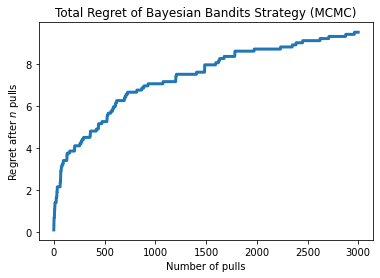

In [ ]:
import numpy as np
import pymc as pm
from matplotlib import pyplot as plt

class Bandits(object):

    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """

    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def pull(self, i):
        # i is which arm to pull
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)

class BayesianStrategy(object):

    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """

    def __init__(self, bandits):

        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    def sample_bandits(self, n=1):

        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # sample from the bandits's priors, and select the largest sample

            P0 = pm.Uniform('P0', 0, 1)
            P1 = pm.Uniform('P1', 0, 1)
            P2 = pm.Uniform('P2', 0, 1)

            X0 = pm.Binomial('X0', value = self.wins[0], n = self.trials[0]+1, p = P0, observed = True)
            X1 = pm.Binomial('X1', value = self.wins[1], n = self.trials[1]+1, p = P1, observed = True)
            X2 = pm.Binomial('X2', value = self.wins[2], n = self.trials[2]+1, p = P2, observed = True)

            mcmc0 = pm.MCMC([P0, X0])
            mcmc0.sample(6000, 1000)
            P0_samples = mcmc0.trace('P0')[:]

            mcmc1 = pm.MCMC([P1, X1])
            mcmc1.sample(6000, 1000)
            P1_samples = mcmc1.trace('P1')[:]

            mcmc2 = pm.MCMC([P2, X2])
            mcmc2.sample(6000, 1000)
            P2_samples = mcmc2.trace('P2')[:]

            print()
            print()
            print(k)
            choice = np.argmax([np.random.choice(P0_samples), np.random.choice(P1_samples), np.random.choice(P2_samples)])

            # sample the chosen bandit
            result = self.bandits.pull(choice)

            # update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)

bayesian_strat = BayesianStrategy(bandits)

bayesian_strat.sample_bandits(3000)

def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

_regret = regret(hidden_prob, bayesian_strat.choices)
plt.plot(_regret, lw=3)

plt.title("Total Regret of Bayesian Bandits Strategy (MCMC)")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls")
plt.show()